In [48]:
# libraries
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from numba import njit

In [49]:
def Lat_Energy(lattice):
    kernal = generate_binary_structure(1, 1) 
    kernal[1] = False
    arr = -lattice*convolve(lattice, kernal, mode = 'constant', cval = 0)
    return np.sum(arr)/2

In [50]:
@njit(nopython = True, nogil = True)
def metropolis(lat_config, n_times, BJ, lattice_energy, N):
    spin_arr = lat_config.copy()
    net_spins = np.zeros(n_times-1)
    net_lattice_energy = np.zeros(n_times-1)

    for t in range(0, n_times-1):

        '''pick random point on array and flip spin'''
        x = np.random.randint(low = 0, high = N)

        spin_i = spin_arr[x]     # initial spin
        spin_f = spin_i*(-1)        # flipping initial spin
        
        '''compute change in lattice_energy'''
        E_i = 0
        E_f = 0

        '''Conditions are such to accomodate boundary spins'''
        # Check if this can be sped up using convolution
        if x > 0:
            E_i += -spin_i*spin_arr[x-1]
            E_f += -spin_f*spin_arr[x-1]
        if x < N-1:
            E_i += -spin_i*spin_arr[x+1]
            E_f += -spin_f*spin_arr[x+1]

        dE = E_f - E_i
        '''transitioninig to new state with giving probability'''
        if ((dE > 0) and (np.random.random() < np.exp(-BJ*dE))):
            spin_arr[x] = spin_f
            lattice_energy += dE
        elif dE <= 0:
            spin_arr[x] = spin_f
            lattice_energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_lattice_energy[t] = lattice_energy
            
    return net_spins, net_lattice_energy

c:\Users\jains\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [51]:
def get_spin_energy(lattice, BJs, correct_n, N):
    ms = np.zeros(len(BJs))         # array for means of spins
    e_means = np.zeros(len(BJs))
    e_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 10**6, bj, Lat_Energy(lattice), N)

        # correct_n is the number of spins/particles (from the end of the array) that we'd like to consider to calc. the mean and std. It is like convergence
        ms[i] = np.mean(spins[-correct_n:])/N**2
        e_means[i] = np.mean(energies[-correct_n:])
        e_stds[i] = np.std(energies[-correct_n:])

    return ms, e_means, e_stds

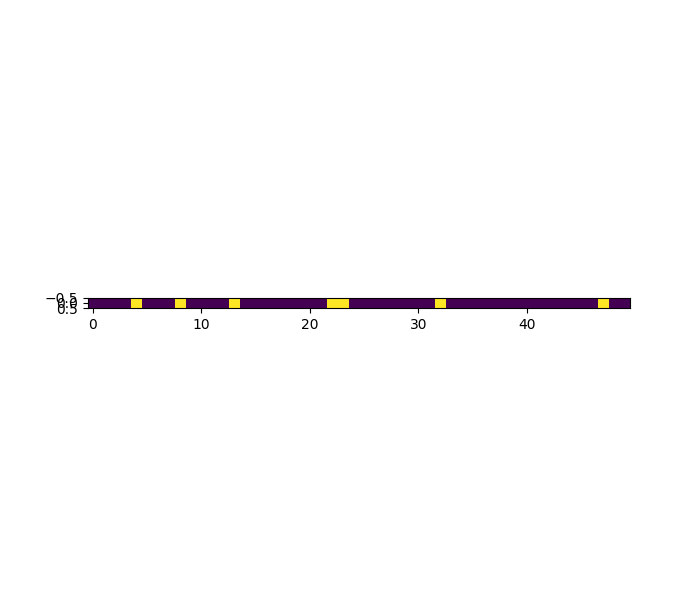

In [52]:
'''Lattice Information'''
N = 50              # N Chain
p = 0.75            # Prob of -1 spins
BJ = 0.75           # Energy of one alignment
chain = np.random.choice([-1, 1], size = (1, N), p = [p, 1-p])
plt.figure("chain")
plt.imshow(chain)
lattice = chain[0]

In [53]:
lat = np.array([1, 1])
print(lat)
lat_e = Lat_Energy(lat)
print(lat_e)

[1 1]
-1.0


In [54]:
n_steps = 10**6     # Number of times to run metropolis: (randomly) flip spins
energy_lattice = Lat_Energy(lattice)

spin, enrgy = metropolis(lat_config = lattice, n_times = n_steps, BJ = BJ, lattice_energy = energy_lattice, N = N)

In [55]:
# '''Plot of Spins and Energy for particular BJ'''
# fig, ax = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
# ax[0].plot(spin/N**2)
# ax[0].set_xlabel("n Steps")
# ax[0].set_ylabel("Average Spin $\\bar{m}$")
# ax[0].grid(True)
# ax[1].plot(enrgy)
# ax[1].set_xlabel("n Steps")
# ax[1].set_ylabel("Energy $E/J$")
# ax[1].grid(True)
# fig.suptitle("Average Spin and Energy for $\\beta J = $ {:}".format(BJ), size = 12); 

Text(0, 0.5, '$\\bar{m}$')

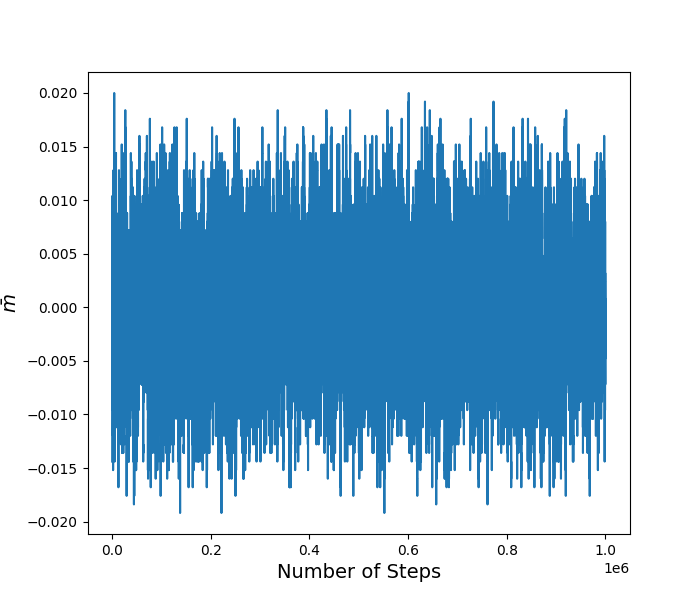

In [56]:
plt.figure("1D_avg_spin_onetime")
plt.rcParams['figure.figsize'] = [7, 6]
plt.plot(np.linspace(0, n_steps, n_steps-1), spin/N**2)
plt.xlabel("Number of Steps", fontsize = 14)
plt.ylabel("$\\bar{m}$", fontsize = 14)

# plt.savefig("1D_avg_spin_onetime")

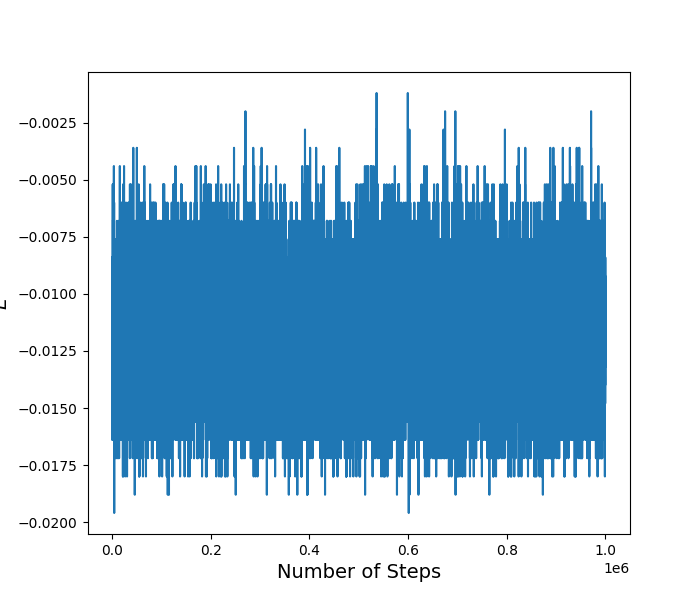

In [57]:
plt.figure("1D_energy_onetime")
plt.rcParams['figure.figsize'] = [7, 6]
plt.plot(enrgy/N**2)
plt.xlabel("Number of Steps", fontsize = 14)
plt.ylabel("$\\bar{E}$", fontsize = 14)
plt.show()

In [58]:
BJs = np.arange(0.1, 20, 0.05)
s_means, E_means, E_stds = get_spin_energy(lattice, BJs, 10**5, N)

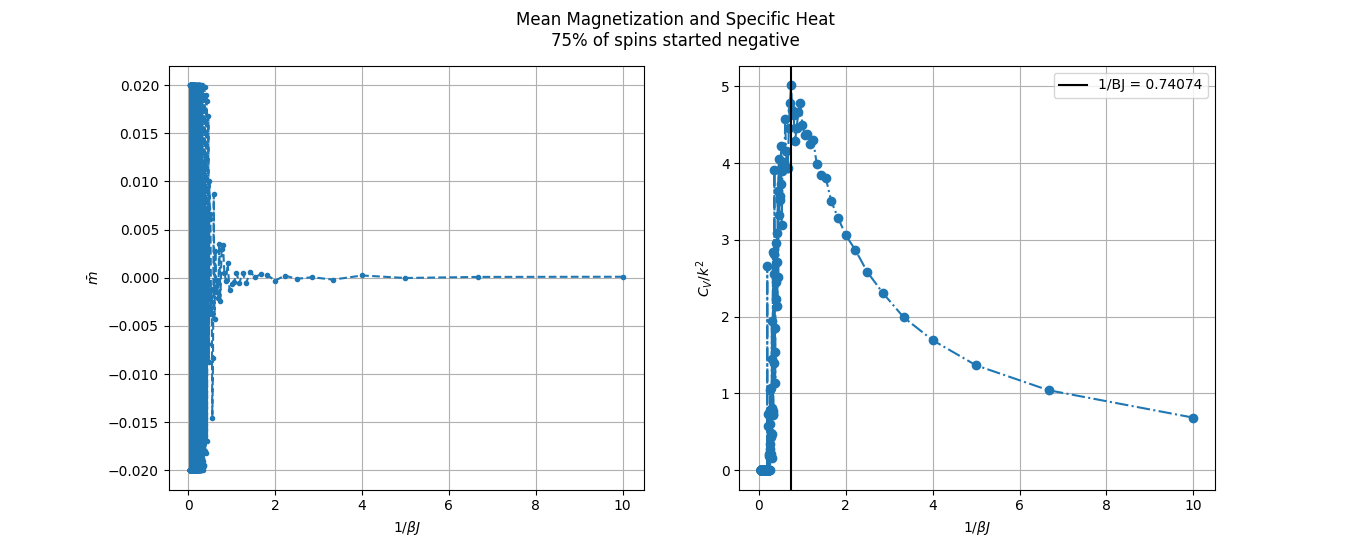

In [59]:
'''Plot of Magnetization and Cv vs 1/BJ'''
fig2, ax2 = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
# ms_max_ind = np.argmax(s_means)
ax2[0].plot(1/BJs, s_means, ls = '--', marker = ".")
# ax2[0].axvline(1/BJs[ms_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[ms_max_ind]))
ax2[0].set_xlabel("$1/\\beta J$")
ax2[0].set_ylabel("$\\bar{m}$")
ax2[0].grid()
# ax2[0].legend()

cv_max_ind = np.argmax(E_stds*BJs)
ax2[1].plot(1/BJs, E_stds*BJs, ls = "-.", marker = "o")
ax2[1].axvline(1/BJs[cv_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[cv_max_ind]))
ax2[1].set_xlabel("$1/\\beta J$")
ax2[1].set_ylabel("$C_V / k^2$")
ax2[1].grid()
ax2[1].legend()
fig2.suptitle("Mean Magnetization and Specific Heat\n{:}% of spins started negative".format(int(p*100))); 

Text(0, 0.5, '$\\bar{m}$')

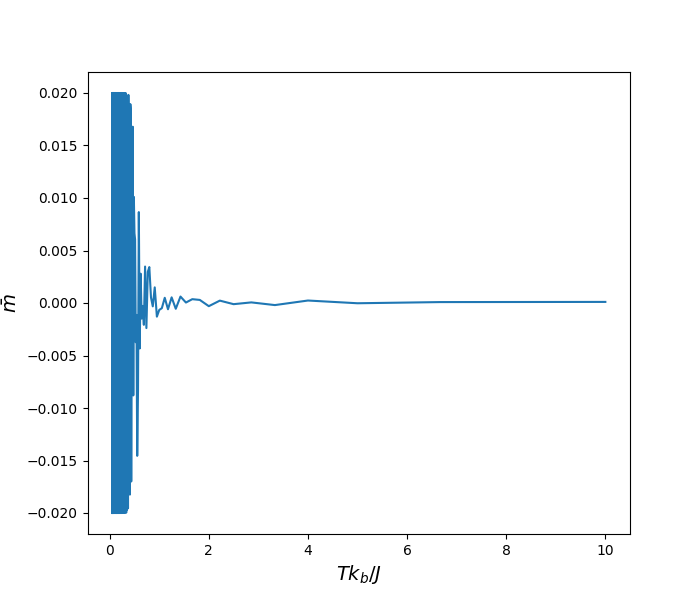

In [60]:
plt.figure("1D_avg_spin_multiple")
plt.rcParams['figure.figsize'] = [7, 6]
plt.plot(1/BJs, s_means, ls = '-')
# ax2[0].axvline(1/BJs[ms_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[ms_max_ind]))
plt.xlabel("$Tk_b/J$", fontsize = 14)
plt.ylabel("$\\bar{m}$", fontsize = 14)

Text(0, 0.5, '$\\bar{E}$')

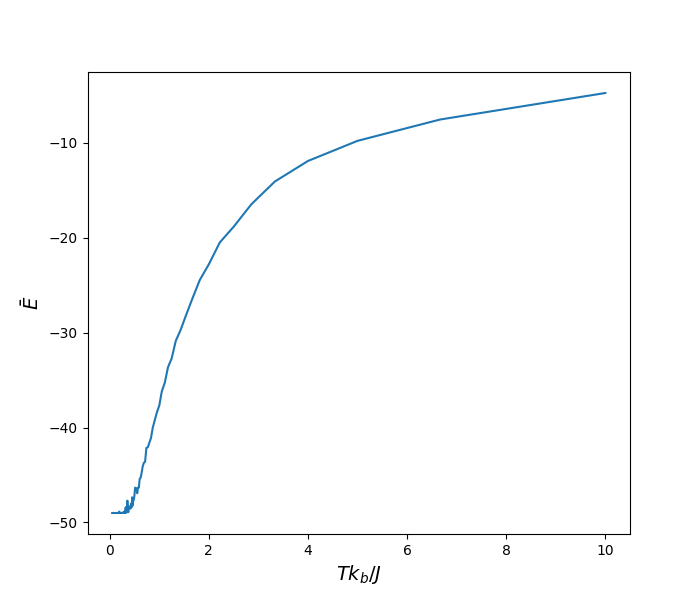

In [61]:
plt.figure("1D_avg_enrgy_multiple")
plt.rcParams['figure.figsize'] = [7, 6]
plt.plot(1/BJs, E_means, ls = '-')
# ax2[0].axvline(1/BJs[ms_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[ms_max_ind]))
plt.xlabel("$Tk_b/J$", fontsize = 14)
plt.ylabel("$\\bar{E}$", fontsize = 14)

Behaviour of $\bar{m}$ suggests that there is no phase transition. Moreover, bunching of points around maxima in $C_V/k^2$ suggests that there is no discontinuity (or atleast not infinite discontinuity which is demanded by fluctuation-dissipation theorem). Hence, it can be infered that there is no phase transition in 1-D case of ising model.

In [62]:
'''Comparing Positive and Negative Lattices'''
lattice_n = np.random.choice([-1, 1], size = (1, N), p = [p, 1-p])[0]
lattice_p = np.random.choice([-1, 1], size = (1, N), p = [1-p, p])[0]
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs, 10**5, N)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs, 10**5, N)

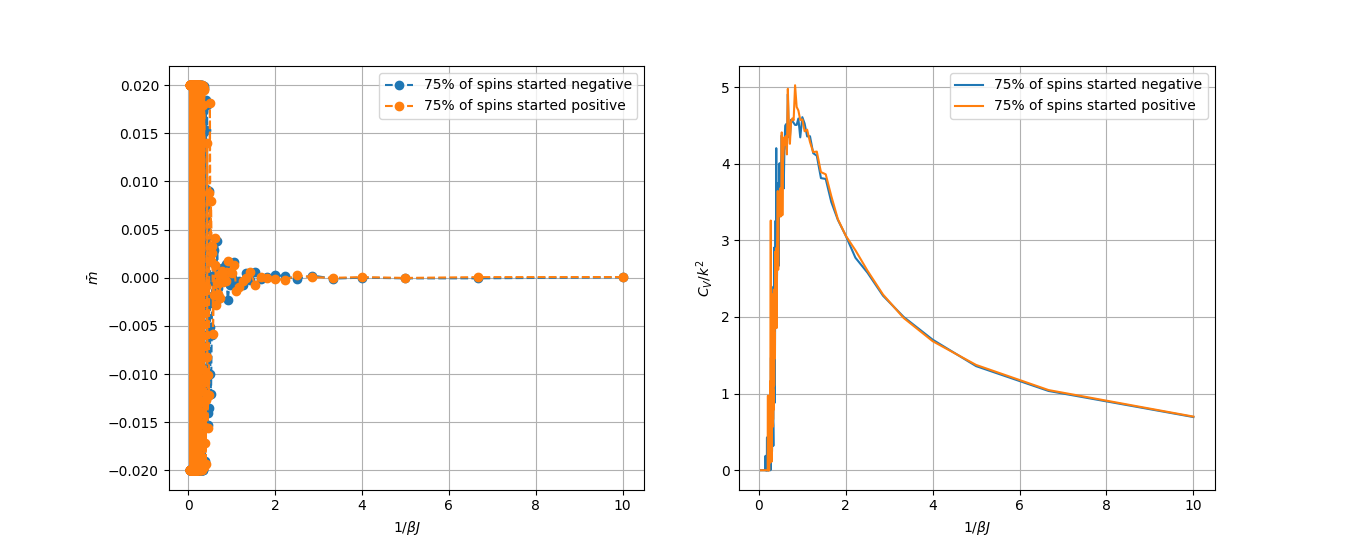

In [63]:
fig3, ax3 = plt.subplots(1, 2, figsize = (13.5, 5.5)); 

ax3[0].plot(1/BJs, ms_n, "o--", label = "{:}% of spins started negative".format(int(p*100)))
ax3[0].plot(1/BJs, ms_p, "o--", label = "{:}% of spins started positive".format(int(p*100)))
ax3[0].set_xlabel("$1/\\beta J$")
ax3[0].set_ylabel("$\\bar{m}$")
ax3[0].grid()
ax3[0].legend()

ax3[1].plot(1/BJs, E_stds_n*BJs, label = "{:}% of spins started negative".format(int(p*100)))
ax3[1].plot(1/BJs, E_stds_p*BJs, label = "{:}% of spins started positive".format(int(p*100)))
ax3[1].set_xlabel("$1/\\beta J$")
ax3[1].set_ylabel("$C_V / k^2$")
ax3[1].grid()
ax3[1].legend()